# `likelihood.py`

This notebook tests the `likelihood.py` module.

This module contains several methods designed to evaluate the probability of an event to be assigned to a component of the mixture and to evaluate the expected value of mean and covariance matrix of each of these components, both conditioned on the events already assigned to the component.

## Utilities

First of all, we will test some utility methods used by the main methods.

### `inv_jit`


Numba-decorated `numpy.linalg.inv` method. Faster than pure Numpy on a single matrix.

In [3]:
import numpy as np

from figaro.likelihood import inv_jit
from scipy.stats import invwishart

M = invwishart(3, np.identity(3)).rvs()

print('Numpy:')
%timeit np.linalg.inv(M)
print('Numba:')
%timeit inv_jit(M)

print(np.allclose(np.linalg.inv(M), inv_jit(M), atol = 1e-16))

Numpy:
39.2 µs ± 10 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Numba:
3.09 µs ± 323 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
True


### `logdet_jit`

Numba-decorated logarithm of `numpy.linalg.det` method. Faster than pure Numpy on a single matrix.

In [7]:
from figaro.likelihood import logdet_jit

M = invwishart(3, np.identity(3)).rvs()
print('Numpy:')
%timeit np.log(np.linalg.det(M))
print('Numba:')
%timeit logdet_jit(M)

print(np.allclose(np.log(np.linalg.det(M)), logdet_jit(M), atol = 1e-13))

Numpy:
12.3 µs ± 3.09 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Numba:
The slowest run took 21.13 times longer than the fastest. This could mean that an intermediate result is being cached.
5.34 µs ± 9.01 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
True


### `logsumexp_jit`

Numba-decorated and check-free version of `scipy.special.logsumexp`. See https://github.com/scipy/scipy/blob/v1.8.0/scipy/special/_logsumexp.py#L7-L127

In [8]:
from figaro.likelihood import logsumexp_jit
from scipy.special import logsumexp

n_pts = 1000

p = np.log(np.random.uniform(0,1, size = n_pts))
b = np.linspace(0,1,n_pts)

print('Numpy:')
%timeit logsumexp(p, b=b)
print('Numba:')
%timeit logsumexp_jit(p, b=b)

print('Numpy: {0}, Numba: {0}'.format(logsumexp(p, b=b), logsumexp_jit(p, b=b)))

Numpy:
121 µs ± 25.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Numba:
The slowest run took 14.55 times longer than the fastest. This could mean that an intermediate result is being cached.
31.1 µs ± 49.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy: 5.499549791707572, Numba: 5.499549791707572


### `scalar_product`

Given a matrix $M$ and a vector $v$, computes $\langle v, Mv\rangle$. Compared with `np.dot(v, np.dot(M, v))`.

In [10]:
from figaro.likelihood import scalar_product

M = invwishart(3, np.identity(3)).rvs()
v = np.random.uniform(size = 3)

print('Numpy:')
%timeit np.dot(v, np.dot(M, v))
print('Numba:')
%timeit scalar_product(v, M, len(v))

print(np.alltrue(scalar_product(v, M, len(v)) == np.dot(v, np.dot(M, v))))

Numpy:
3.54 µs ± 372 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
Numba:
714 ns ± 38.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
True


### `log_norm_1d`

Log PDF of 1-dimensional Gaussian distribution, to be compared with Scipy's `norm().logpdf`. Works with doubles.

In [12]:
from figaro.likelihood import log_norm_1d
from scipy.stats import norm

mu  = 2
var = 0.1
x   = np.linspace(-5,5,1000)

logpdf_scipy = norm(mu, np.sqrt(var)).logpdf(x)
logpdf_figaro = np.array([log_norm_1d(xi, mu, var) for xi in x])

print(np.alltrue(logpdf_scipy == logpdf_figaro))

False


The element-wise comparison seems to fail: let's have a look at the differences.

True


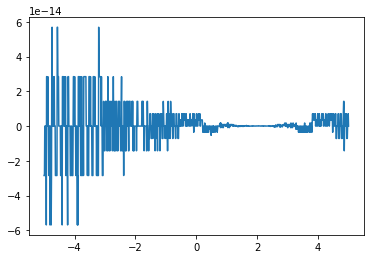

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
a = ax.plot(x, logpdf_figaro - logpdf_scipy)

print(np.allclose(logpdf_scipy, logpdf_figaro, atol = 1e-13, rtol = 0))

### `log_norm`

Log PDF of N-dimensional Gaussian distribution, to be compared with Scipy's `multivariate_normal().logpdf`. Works with doubles.

In [45]:
from figaro.likelihood import log_norm
from scipy.stats import multivariate_normal

mu  = np.zeros(2)
var = np.identity(2)*0.1**2
x   = np.linspace(0,1,100)
y   = np.linspace(0,1,100)


z = []
for xi in x:
    for yi in y:
        z.append(np.array([xi,yi]))
z = np.array(z)

logpdf_scipy  = multivariate_normal(mu, var).logpdf(z)
logpdf_figaro = np.array([log_norm(zi, mu, var) for zi in z])

print(np.alltrue(logpdf_scipy == logpdf_figaro))

False


The element-wise comparison seems to fail: let's have a look at the differences.

True


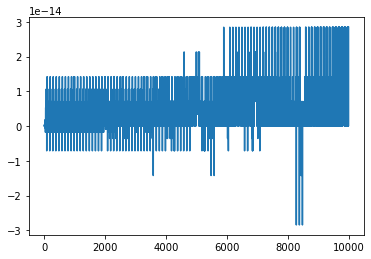

In [48]:
fig, ax = plt.subplots()
a = ax.plot((logpdf_figaro - logpdf_scipy))

print(np.allclose(logpdf_scipy, logpdf_figaro, atol = 1e-13, rtol = 0))

# Reviewer

The code is reliable when the functions listed above are evaluated for values >> absolute error.
Reviewed commit 